In [25]:
from ThesisPackage.Environments.collectors.collectors_env_discrete_onehot import Collectors
from ThesisPackage.RL.Centralized_PPO.multi_ppo import PPO_Multi_Agent_Centralized
from ThesisPackage.RL.Decentralized_PPO.util import flatten_list, reverse_flatten_list_with_agent_list
from ThesisPackage.Wrappers.vecWrapper import PettingZooVectorizationParallelWrapper
import torch
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

In [26]:
def make_env(sequence_length=0, vocab_size=4):
    max_episode_steps = 2048
    env = Collectors(width=20, height=20, vocab_size=vocab_size, sequence_length=sequence_length, max_timesteps=max_episode_steps, timestep_countdown=15)
    # env = ParallelFrameStack(env, 4)
    return env

In [27]:
def load(path="models/checkpoints", sequence_length=2):
    env = make_env(sequence_length)
    models = {}
    for model in os.listdir(path):
        if f"collect_seq_{sequence_length}" in model:
            try:
                state_dict = torch.load(os.path.join(path, model))
                timestamp = model.split("_")[-1]
                timestamp = int(timestamp.split(".")[0])
                agent = PPO_Multi_Agent_Centralized(env, device="cpu")
                agent.agent.load_state_dict(state_dict)
                models[timestamp] = agent
            except:
                pass
    return models

In [28]:
num_steps = 10000
models = {}
for i in [1, 2, 3, 4]:
    agents = load("/Users/cowolff/Documents/GitHub/ma.pong_rl/models/checkpoints_collectors_2/models/checkpoints", sequence_length=i)
    models[i] = agents
agent_indizes = list(agents.keys())
agent_indizes.sort()

In [29]:
def get_means(env, model, epochs):
    means = []
    tokens = {channel: {0: 0, 1: 1, 2: 2} for channel in [1, 2]}
    for i in range(epochs):
        obs, info = env.reset()
        state = env.state()
        while True:
            obs = [obs]
            state = [state]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))
            means.append(obs)
            obs = torch.tensor(obs, dtype=torch.float32)
            state = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                action, _, _, _ = model.agent.get_action_and_value(obs, state)
                action = reverse_flatten_list_with_agent_list(action, env.agents)[0]
            
            action = {agent: cur_action.numpy() for agent, cur_action in action.items()}
            obs, rewards, terminations, truncations, info = env.step(action)
            state = env.state()
            for channel in [1, 2]:
                for paddle in env.agents:
                    cur_token = int(obs[paddle][-1 * channel])
                    tokens[channel][cur_token] += 1
            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                break
    means = np.stack(means)
    return means, tokens

In [30]:
def integrated_gradients(inputs, model, target_label_idx, baseline=None, steps=100, normalize=True, absolute_gradients=True):
    """
    Compute Integrated Gradients for a given input and model.
    Args:
        inputs (torch.Tensor): Input tensor for which gradients are computed.
        model (torch.nn.Module): Model used for inference.
        target_label_idx (int): Target label index for which the gradients are computed.
        baseline (torch.Tensor, optional): Baseline input to compare against. Defaults to a zero tensor of the same shape as inputs.
        steps (int): Number of interpolation steps between baseline and input.
        normalize (bool): Whether to normalize the integrated gradients between 0 and 1. Defaults to True.
        absolute_gradients (bool): Whether to return only the absolute values of the gradients. Defaults to False.
    Returns:
        numpy.ndarray: Integrated gradients, optionally normalized.
        list of numpy.ndarray: Individual gradients for each step, optionally with absolute values.
        list of numpy.ndarray: Individual interpolated input samples used.
    """
    model.eval()  # Ensure model is in evaluation mode
    if baseline is None:
        baseline = torch.zeros_like(inputs)
    assert baseline.shape == inputs.shape
    
    grads = []
    all_inputs = []
    
    for i in range(steps + 1):
        scaled_input = torch.tensor(baseline + ((float(i) / steps) * (inputs - baseline)), requires_grad=True)
        logits = model(scaled_input)
        loss = logits[0, target_label_idx]
        loss.backward()
        
        if absolute_gradients:
            grad_data = scaled_input.grad.data.cpu().numpy()  # Get the gradient data
            grads.append(np.abs(grad_data))  # Append the absolute value of gradients
        else:
            grads.append(scaled_input.grad.data.cpu().numpy())  # Append the raw gradients
        
        all_inputs.append(scaled_input.detach().cpu().numpy())
        model.zero_grad()
    
    # Average the gradients excluding the last one (at input)
    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grad = (inputs.detach().cpu().numpy() - baseline.cpu().numpy()) * avg_grads
    
    if normalize:
        # Normalize the integrated gradients between 0 and 1
        min_val = np.min(integrated_grad)
        max_val = np.max(integrated_grad)
        if max_val > min_val:  # Avoid division by zero
            normalized_integrated_grad = (integrated_grad - min_val) / (max_val - min_val)
        else:
            normalized_integrated_grad = integrated_grad  # If all values are the same, return as is
    else:
        normalized_integrated_grad = integrated_grad
    
    return normalized_integrated_grad, grads, all_inputs

In [31]:
def smoothgrad(inputs, model, target_label_idx, noise_level=0.1, num_samples=50, min_val=None, max_val=None, normalize=True, absolute_gradients=True):
    """
    Compute SmoothGrad for a given input and model.
    
    Args:
        inputs (torch.Tensor): Input tensor for which gradients are computed.
        model (torch.nn.Module): Model used for inference.
        target_label_idx (int): Target label index for which the gradients are computed.
        noise_level (float): Standard deviation of noise added to inputs.
        num_samples (int): Number of noisy samples to generate.
        min_val (float or torch.Tensor, optional): Minimum value(s) that inputs should not drop below. Defaults to None.
        max_val (float or torch.Tensor, optional): Maximum value(s) that inputs should not exceed. Defaults to None.
        normalize (bool): Whether to normalize the averaged gradients between 0 and 1. Defaults to True.
        absolute_gradients (bool): Whether to use the absolute values of the gradients. Defaults to False.
    
    Returns:
        numpy.ndarray: Smoothed gradients averaged over noisy samples, optionally normalized.
        list of numpy.ndarray: Individual gradients for each sample.
        list of numpy.ndarray: Individual noisy input samples used.
    """
    model.eval()  # Ensure model is in evaluation mode
    inputs = inputs.detach()
    grads = []
    all_inputs = []
    
    for _ in range(num_samples):
        # Add noise to the inputs
        noisy_input = inputs + noise_level * torch.randn_like(inputs)
        
        # Clip the noisy input to ensure it stays within min_val and max_val
        if min_val is not None:
            noisy_input = torch.clamp(noisy_input, min=min_val)
        if max_val is not None:
            noisy_input = torch.clamp(noisy_input, max=max_val)
        
        noisy_input.requires_grad = True
        
        # Forward pass
        logits = model(noisy_input)
        loss = logits[0, target_label_idx]
        
        # Backward pass
        loss.backward()
        
        if absolute_gradients:
            grads.append(np.abs(noisy_input.grad.data.cpu().numpy()))
        else:
            grads.append(noisy_input.grad.data.cpu().numpy())
        
        all_inputs.append(noisy_input.detach().cpu().numpy())
        
        # Clear gradients
        model.zero_grad()
    
    # Average the gradients
    avg_grads = np.mean(grads, axis=0)
    
    if normalize:
        # Normalize the averaged gradients between 0 and 1
        min_val_avg = np.min(avg_grads)
        max_val_avg = np.max(avg_grads)
        if max_val_avg > min_val_avg:  # Avoid division by zero
            normalized_avg_grads = (avg_grads - min_val_avg) / (max_val_avg - min_val_avg)
        else:
            normalized_avg_grads = avg_grads  # If all values are the same, return as is
    else:
        normalized_avg_grads = avg_grads
    
    return normalized_avg_grads, grads, all_inputs

In [32]:
def compute_saliency(agent, env, obs, tracking_index, normalize=True):
    """
    Compute saliency for a given observation and agent.
    
    Args:
        agent: The agent object containing the actor model.
        env: The environment object providing necessary parameters like sequence length and vocab size.
        obs (numpy.ndarray): Observations used for computing saliency.
        tracking_index (int): Index of the observation to track.
        normalize (bool): Whether to normalize the saliency values between 0 and 1. Defaults to True.
    
    Returns:
        numpy.ndarray: Importances based on saliency, optionally normalized.
        numpy.ndarray: Full saliency map, optionally normalized.
    """
    obs_track = torch.tensor(np.expand_dims(obs[tracking_index], axis=0), dtype=torch.float32, requires_grad=True)
    logits = agent.agent.actor(obs_track)
    
    agent.agent.actor.zero_grad()
    
    grad_tensor = torch.zeros_like(logits)
    grad_tensor[:, :-env.sequence_length * env.vocab_size] = 1
    
    logits.backward(grad_tensor)
    
    saliency = obs_track.grad.data.abs().numpy()
    
    if normalize:
        # Normalize the saliency values between 0 and 1
        min_val = saliency.min()
        max_val = saliency.max()
        if max_val > min_val:  # Avoid division by zero
            saliency_normalized = (saliency - min_val) / (max_val - min_val)
        else:
            saliency_normalized = saliency  # If all values are the same, return as is
    else:
        saliency_normalized = saliency
    
    importances_saliency = np.max(saliency_normalized[:, -env.sequence_length * env.vocab_size:], axis=1)
    
    return importances_saliency, saliency_normalized

In [33]:
def plot_and_save_xy_data(x_array, y_array, original_inputs, save_path='xy_plot.png'):
    """
    Plots the data with x-values from one array and y-values from another, 
    and saves the plot as an image file.

    Parameters:
    - x_array: numpy array of shape (10, 3) representing x-values
    - y_array: numpy array of shape (10, 3) representing y-values
    - save_path: string, path to save the plot image file
    """
    plt.figure(figsize=(10, 6))

    # Draw a red vertical line at each x-value in original_inputs
    for x_val in original_inputs:
        plt.axvline(x=x_val, color='red', linestyle='--', linewidth=1)
    
    # Plot lines for each of the three dimensions (columns)
    for i in range(3):
        plt.scatter(x_array[:, i], y_array[:, i], label=f'Column {i+1}', marker='o')

    # Adding labels, legend, and title
    plt.xlabel('X Values')
    plt.ylabel('Y Values')
    plt.title('XY Plot for Three Columns')
    plt.legend()
    plt.grid(True)

    # Save the plot
    plt.savefig(save_path)
    plt.close()

In [75]:
def test_integrated_gradients_and_saliency(agent, env, means, smaller=True, threshold=0.5, noise=False, epochs=1, timesteps=1024, tracking_agent="player_1"):
    integrated_grad_saliencies = []
    saliency_saliencies = []
    integrated_full_saliencies_means = []
    saliency_full_saliencies = []
    smoothgrad_full_saliencies = []
    integrated_full_saliencies_zeros = []

    smoothgrad_full_saliencies_small = []
    smoothgrad_full_saliencies_large = []

    obs, info = env.reset()
    average_lengths = []
    tokens = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} out of {epochs}")
        timestep = 0

        while timestep < timesteps:
            timestep += 1

            agent.agent.actor.zero_grad()

            # Tracking agent index
            tracking_index = env.agents.index(tracking_agent)

            # Prepare observations and states
            tokens.append(obs[tracking_agent][-1 * env.sequence_length * env.vocab_size:])
            obs = [obs]
            state = [env.state()]
            obs = np.array(flatten_list(obs))
            state = np.array(flatten_list(state))

            # Integrated Gradients
            obs_track = torch.tensor(np.expand_dims(obs[tracking_index], axis=0), dtype=torch.float32, requires_grad=True)


            baselines = torch.tensor(np.expand_dims(means, axis=0), dtype=torch.float32)
            integrated_grads_means, grads, all_inputs = integrated_gradients(obs_track, agent.agent.actor, 0, baseline=baselines, steps=40)
            language_saliences_integrated = np.sum(integrated_grads_means[0, -1 * env.sequence_length:])

            agent.agent.actor.zero_grad()

            zero_baselines = torch.zeros_like(baselines)
            integrated_grads_zeros, grads, all_inputs = integrated_gradients(obs_track, agent.agent.actor, 0, baseline=zero_baselines, steps=40)
            language_saliences_integrated_zeros = np.sum(integrated_grads_zeros[0, -1 * env.sequence_length:])

            agent.agent.actor.zero_grad()

            smooth_grads, grads, all_inputs = smoothgrad(obs_track, agent.agent.actor, 0, num_samples=30)

            agent.agent.actor.zero_grad()

            smooth_grads_small, grads, all_inputs = smoothgrad(obs_track, agent.agent.actor, 0, num_samples=30, noise_level=0.1)

            agent.agent.actor.zero_grad()

            smooth_grads_large, grads, all_inputs = smoothgrad(obs_track, agent.agent.actor, 0, num_samples=30, noise_level=0.5)

            agent.agent.actor.zero_grad()

            # Saliency
            importances_saliency, saliency = compute_saliency(agent, env, obs, tracking_index)

            # Agent Actions
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            state_tensor = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                actions, _, _, _ = agent.agent.get_action_and_value(obs_tensor, state_tensor)
                actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

            actions = actions[0]
            actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

            # Append results
            integrated_grad_saliencies.append(language_saliences_integrated)
            saliency_saliencies.append(importances_saliency)
            integrated_full_saliencies_means.append(integrated_grads_means)
            integrated_full_saliencies_zeros.append(integrated_grads_zeros)
            saliency_full_saliencies.append(saliency)
            smoothgrad_full_saliencies.append(smooth_grads)
            smoothgrad_full_saliencies_small.append(smooth_grads_small)
            smoothgrad_full_saliencies_large.append(smooth_grads_large)

            # Environment step
            obs, _, truncations, terminations, infos = env.step(actions)

            if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                average_lengths.append(timestep)
                obs, info = env.reset()

    # Convert results to arrays
    integrated_full_saliencies_means = np.stack(integrated_full_saliencies_means, axis=0)
    integrated_full_saliencies_zeros = np.stack(integrated_full_saliencies_zeros, axis=0)
    saliency_full_saliencies = np.stack(saliency_full_saliencies, axis=0)
    smoothgrad_full_saliencies = np.stack(smoothgrad_full_saliencies, axis=0)
    integrated_grad_saliencies = np.array(integrated_grad_saliencies)
    saliency_saliencies = np.array(saliency_saliencies)

    smoothgrad_full_saliencies_small = np.stack(smoothgrad_full_saliencies_small, axis=0)
    smoothgrad_full_saliencies_large = np.stack(smoothgrad_full_saliencies_large, axis=0)

    return (integrated_grad_saliencies, saliency_saliencies, average_lengths,
            integrated_full_saliencies_means, integrated_full_saliencies_zeros, saliency_full_saliencies, smoothgrad_full_saliencies, smoothgrad_full_saliencies_small, smoothgrad_full_saliencies_large, np.array(tokens))

In [76]:
sequence_length = 2
vocab_size = 4
env = make_env(sequence_length, vocab_size)
means, tokens = get_means(env, models[sequence_length][agent_indizes[-1]], 5)

means = means.reshape(-1, means.shape[-1])
mins, maxs = torch.tensor(np.min(means, axis=0)), torch.tensor(np.max(means, axis=0))

means = np.mean(means, axis=0)

length = 0

while length < 1024:
    integrated_grad_saliencies, saliency_saliencies, average_lengths, integrated_full_saliencies_means, integrated_full_saliencies_zeros, saliency_full_saliencies, smoothgrad_full_saliencies,  smoothgrad_full_saliencies_small, smoothgrad_full_saliencies_large, tokens = test_integrated_gradients_and_saliency(models[2][agent_indizes[-1]], env, means, timesteps=1024)

    length = len(saliency_full_saliencies)
    print(length)

Epoch 1 out of 1


/var/folders/sv/xzgywwf17_d3f25rzb7z7jjh0000gn/T/ipykernel_82108/1471767177.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_input = torch.tensor(baseline + ((float(i) / steps) * (inputs - baseline)), requires_grad=True)


1024


In [77]:
def plot_relative_saliency_distribution_bar(saliency_full_saliencies, sequence_length, vocab_size, title="", safe_paht=None):
    """
    This function computes the relative frequency distribution of saliencies, rounds them to one decimal place,
    and plots the frequency of each rounded saliency value as a bar plot.

    Parameters:
    - saliency_full_saliencies: List or array containing saliency values.
    - sequence_length: Integer, sequence length used for slicing.
    - vocab_size: Integer, vocabulary size used for slicing.

    Returns:
    - None (displays a bar plot).
    """

    # Initialize dictionary to count occurrences of saliencies rounded to 1 decimal place
    count_saliencies = {str(np.round(value, 1)): 0 for value in np.arange(0., 1.1, 0.1)}

    total_count = 0  # Track total saliency values

    # Iterate through saliency values and count occurrences
    for salience in saliency_full_saliencies:
        current_salience = salience[-1 * sequence_length * vocab_size:][0]

        # Round to 1 decimal place
        current_salience = np.round(current_salience, 1)
        for cur in current_salience:
            count_saliencies[str(cur)] += 1
            total_count += 1  # Increment total count

    # Convert to relative frequency
    relative_frequencies = {k: v / total_count for k, v in count_saliencies.items()}

    # Convert keys to float
    float_keys = [float(k) for k in relative_frequencies.keys()]
    values = list(relative_frequencies.values())

    # Plot the data as a bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(float_keys, values, width=0.08, color='b', alpha=0.7)
    plt.xlabel("Saliency Value")
    plt.ylabel("Relative Frequency")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    if safe_paht is not None:
        plt.savefig(safe_paht)
    else:
        plt.show()

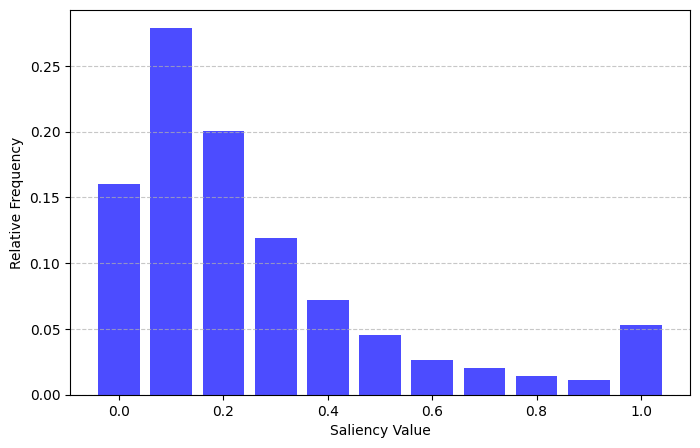

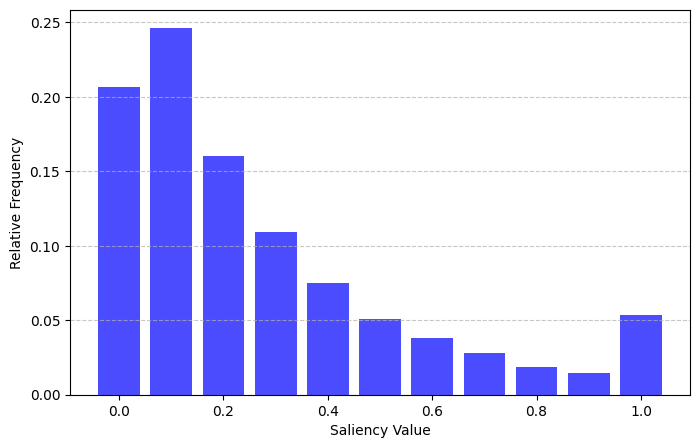

In [ ]:
plot_relative_saliency_distribution_bar(smoothgrad_full_saliencies, sequence_length, vocab_size, safe_paht="/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Relative_Frequency_Saliency/Smoothgrad_Collector_Frequency.pdf")

plot_relative_saliency_distribution_bar(saliency_full_saliencies, sequence_length, vocab_size, safe_paht="/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Relative_Frequency_Saliency/Jacobian_Collector_Frequency.pdf")

plot_relative_saliency_distribution_bar(integrated_full_saliencies_zeros, sequence_length, vocab_size, safe_paht="/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Relative_Frequency_Saliency/Integrated_Gradients_Collector_Frequency.pdf")

In [ ]:
integrated_grad_saliencies, saliency_saliencies, average_lengths, integrated_full_saliencies_means, integrated_full_saliencies_zeros, saliency_full_saliencies, smoothgrad_full_saliencies,  smoothgrad_full_saliencies_small, smoothgrad_full_saliencies_large, tokens = test_integrated_gradients_and_saliency(models[2][agent_indizes[-1]], env, means, timesteps=128)

In [125]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

def plot_saliencies(full_saliencies, path=None, title="Heatmap for one epoch"):
    # Transposing the reshaped data for desired orientation
    data_reshaped = full_saliencies.reshape(-1, full_saliencies.shape[2])
    data_transposed = data_reshaped.T

    # Plotting the heatmap with the new orientation
    plt.figure(figsize=(15, 7))
    plt.imshow(data_transposed, aspect='auto', cmap='viridis')
    plt.colorbar(label='Values')
    plt.title(title)
    plt.xlabel('Timestep')
    plt.ylabel('Features')

    red_line = mlines.Line2D([], [], color='red', label='Language Channel')

    # Adding a red box around the last two features (4 and 5)
    rect = plt.Rectangle((-0.1, 12.5), data_reshaped.shape[0] - 0.9, sequence_length * vocab_size - 0.1, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.legend(handles=[red_line])

    if path != None:
        plt.savefig(path)
    else:
        plt.show()

In [126]:
def plot_double_saliencies(saliencies1, saliencies2, path=None, title="Gradient Heatmaps"):
    # Transposing the reshaped data for desired orientation
    data_reshaped1 = saliencies1.reshape(-1, saliencies1.shape[2])
    data_transposed1 = data_reshaped1.T

    data_reshaped2 = saliencies2.reshape(-1, saliencies2.shape[2])
    data_transposed2 = data_reshaped2.T

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)  # sharey ensures the same y scale
    
    # Plotting the heatmap on the first subplot
    im1 = axs[0].imshow(data_transposed1, aspect='auto', cmap='viridis')
    axs[0].set_title(f"{title} - Means")
    axs[0].set_xlabel('Timestep')
    axs[0].set_ylabel('Features')

    # Plotting the heatmap on the second subplot
    im2 = axs[1].imshow(data_transposed2, aspect='auto', cmap='viridis')
    axs[1].set_title(f"{title} - Zeros")
    axs[1].set_xlabel('Timestep')

    # Adding a red box around the last two features (4 and 5) for both plots
    rect1 = plt.Rectangle((-0.1, 12.5), data_reshaped1.shape[0] - 0.9, sequence_length * vocab_size - 0.1, linewidth=2, edgecolor='red', facecolor='none')
    axs[0].add_patch(rect1)

    rect2 = plt.Rectangle((-0.1, 12.5), data_reshaped2.shape[0] - 0.9, sequence_length * vocab_size - 0.1, linewidth=2, edgecolor='red', facecolor='none')
    axs[1].add_patch(rect2)

    # Adding a red line to the legend
    red_line = mlines.Line2D([], [], color='red', label='Language Channel')
    fig.legend(handles=[red_line], loc='lower right')

    # Add colorbar next to the first subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im1, cax=cbar_ax, label='Values')

    if path is not None:
        plt.savefig(path)
    else:
        plt.show()

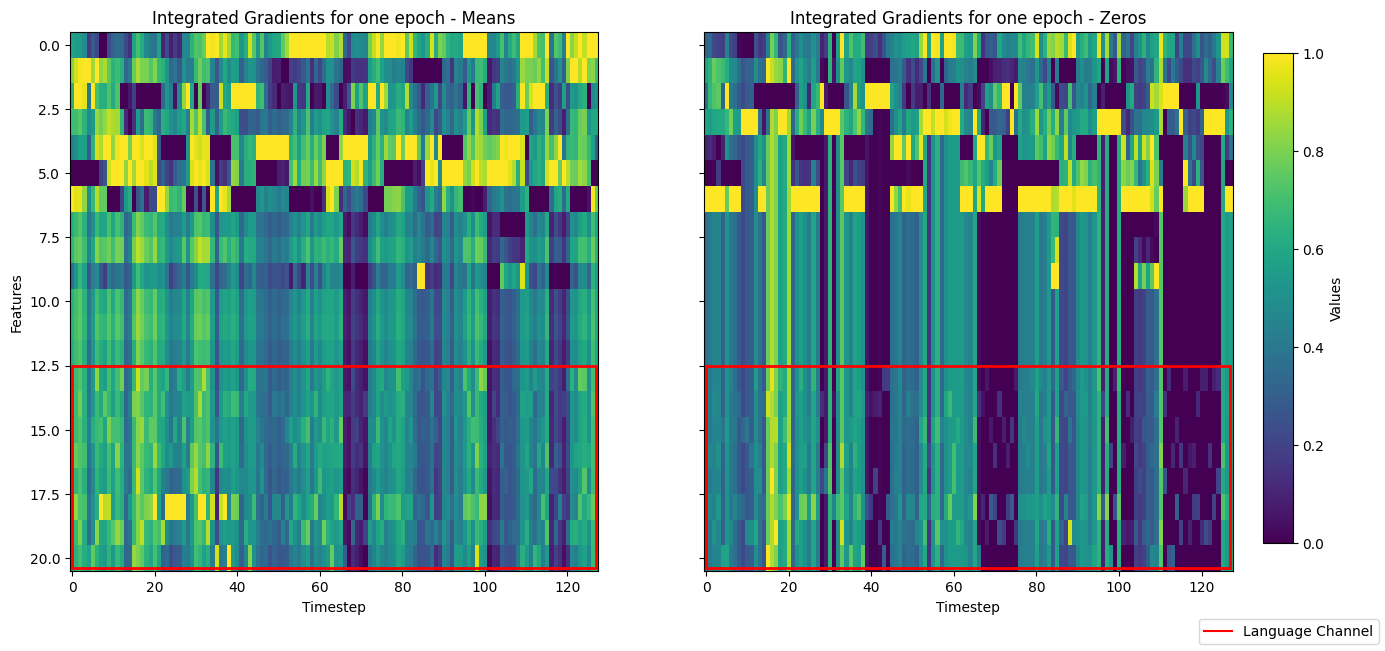

In [127]:
plot_double_saliencies(integrated_full_saliencies_means, integrated_full_saliencies_zeros, title="Integrated Gradients for one epoch", path="/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Means_Zeros_Comparison/Comparison.pdf")

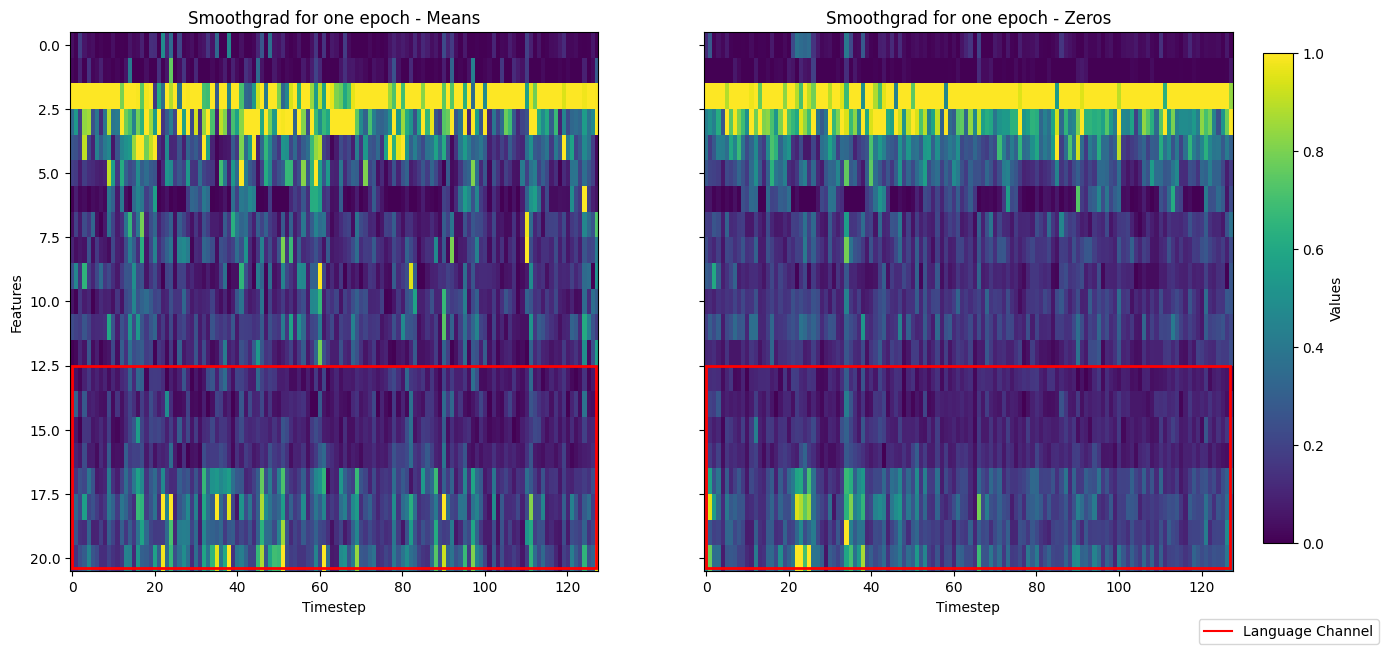

In [128]:
plot_double_saliencies(smoothgrad_full_saliencies_small, smoothgrad_full_saliencies_large, title="Smoothgrad for one epoch", path="/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Means_Zeros_Comparison/SmoothgradComparison.pdf")

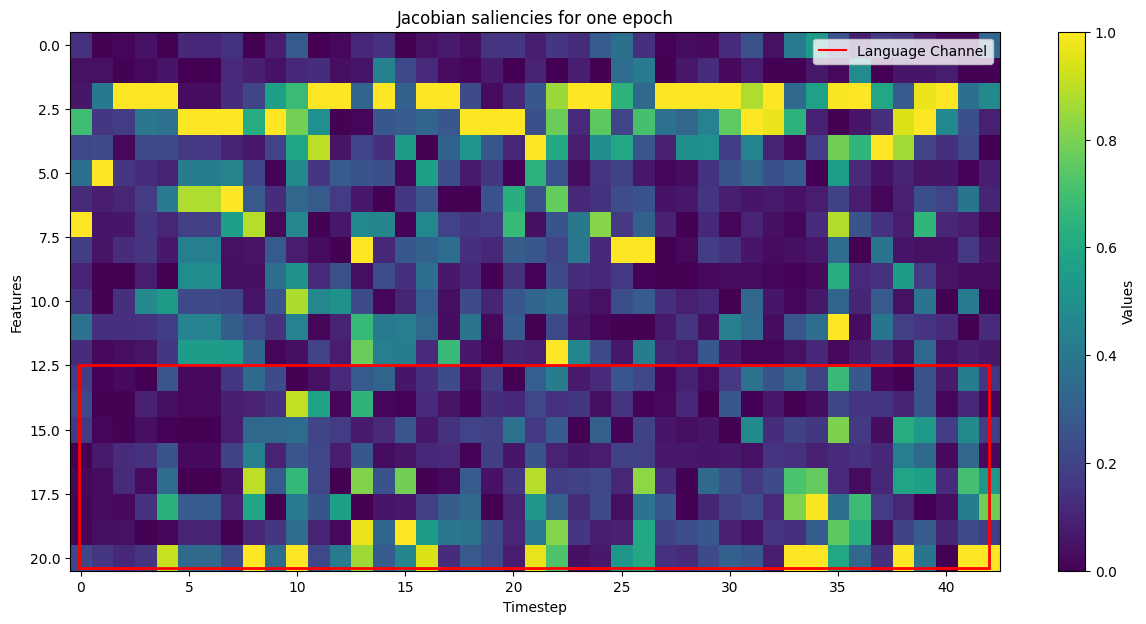

In [95]:
plot_saliencies(saliency_full_saliencies, path="/Users/cowolff/Documents/GitHub/ma.pong_rl/Plotting/Means_Zeros_Comparison/Jacobian_Saliencies.pdf", title="Jacobian saliencies for one epoch")

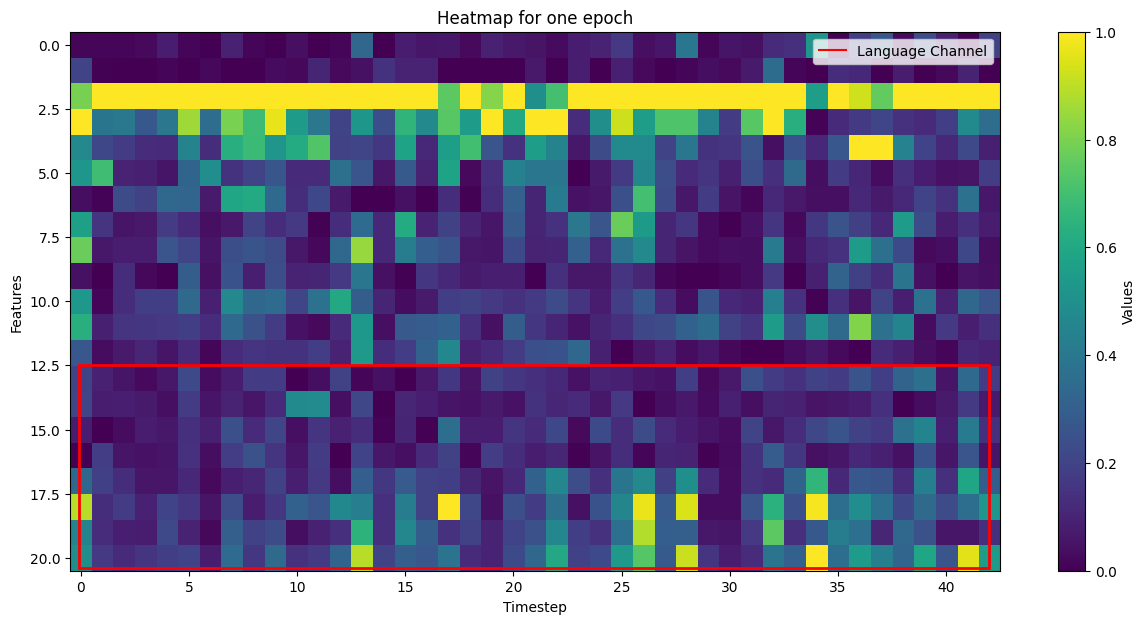

In [96]:
plot_saliencies(smoothgrad_full_saliencies)

# Smoothgrad comparison

In [97]:
import numpy as np
import torch

def test_smoothgrad_steps(agent, env, means, smaller=True, threshold=0.5, noise_levels=[0.1], epochs=1, timesteps=1024, tracking_agent="player_1", min_val=None, max_val=None, num_samples_list=[50]):
    results = {}
    
    for num_samples in num_samples_list:
        results[num_samples] = {}
        
        for noise_level in noise_levels:
            smoothgrad_full_saliencies = []
            obs, info = env.reset()
            average_lengths = []
            tokens = []

            for epoch in range(epochs):
                print(f"Epoch {epoch + 1} out of {epochs}")
                timestep = 0

                while timestep < timesteps:
                    timestep += 1

                    agent.agent.actor.zero_grad()

                    # Tracking agent index
                    tracking_index = env.agents.index(tracking_agent)

                    # Prepare observations and states
                    tokens.append(obs[tracking_agent][-env.sequence_length * env.vocab_size:])
                    obs = [obs]
                    state = [env.state()]
                    obs = np.array(flatten_list(obs))
                    state = np.array(flatten_list(state))

                    obs_track = torch.tensor(np.expand_dims(obs[tracking_index], axis=0), dtype=torch.float32, requires_grad=True)

                    agent.agent.actor.zero_grad()

                    smooth_grads, grads, all_inputs = smoothgrad(obs_track, agent.agent.actor, 0, num_samples=num_samples, noise_level=noise_level, min_val=min_val, max_val=max_val)

                    # Agent Actions
                    obs_tensor = torch.tensor(obs, dtype=torch.float32)
                    state_tensor = torch.tensor(state, dtype=torch.float32)
                    with torch.no_grad():
                        actions, _, _ , _= agent.agent.get_action_and_value(obs_tensor, state_tensor)
                    actions = reverse_flatten_list_with_agent_list(actions, agent.agents)

                    actions = actions[0]
                    actions = {agent: action.cpu().numpy() for agent, action in actions.items()}

                    # Append results
                    smoothgrad_full_saliencies.append(smooth_grads)

                    # Environment step
                    obs, _, truncations, terminations, infos = env.step(actions)

                    if any([truncations[agent] or terminations[agent] for agent in env.agents]):
                        average_lengths.append(timestep)
                        obs, info = env.reset()

            # Convert results to arrays
            smoothgrad_full_saliencies = np.stack(smoothgrad_full_saliencies, axis=0)

            # Calculate the average gradient size for this noise level
            avg_grad_size = np.median(np.linalg.norm(smoothgrad_full_saliencies, axis=(1, 2)))

            # Store the result in the dictionary
            results[num_samples][noise_level] = avg_grad_size

    return results

In [98]:
results = test_smoothgrad_steps(models[2][agent_indizes[-1]], env, means, noise_levels=[0.01, 0.05, 0.1, 0.2, 0.3], num_samples_list=[10, 20, 40], timesteps=1024, min_val=mins, max_val=maxs)

Epoch 1 out of 1
Epoch 1 out of 1
Epoch 1 out of 1
Epoch 1 out of 1
Epoch 1 out of 1
Epoch 1 out of 1


KeyboardInterrupt: 

In [941]:
print(results)

{10: {0.01: 1.6928859, 0.05: 1.6508222, 0.1: 1.5641423, 0.2: 1.5393832, 0.3: 1.5309346}, 20: {0.01: 1.6425276, 0.05: 1.6469715, 0.1: 1.5876966, 0.2: 1.5036416, 0.3: 1.5028341}, 40: {0.01: 1.6907837, 0.05: 1.6315485, 0.1: 1.5571735, 0.2: 1.462713, 0.3: 1.497386}}


In [943]:
def results_to_latex_table(results):
    # Start building the LaTeX table
    latex_table = "\\begin{tabular}{|c"
    
    # Determine the number of noise levels to add columns for
    num_noise_levels = len(next(iter(results.values())))
    latex_table += "|c" * num_noise_levels + "|}\n"
    latex_table += "\\hline\n"
    
    # Add header row with noise levels abbreviated as NL
    latex_table += "Num Samples & "
    latex_table += " & ".join(f"NL {noise_level}" for noise_level in results[next(iter(results))].keys())
    latex_table += "\\\\\\hline\n"
    
    # Iterate over each num_samples and add rows to the table
    for num_samples, noise_data in results.items():
        latex_table += f"{num_samples} & "
        latex_table += " & ".join(f"{avg_grad_size:.4f}" for avg_grad_size in noise_data.values())
        latex_table += "\\\\\\hline\n"
    
    # Close the table
    latex_table += "\\end{tabular}"
    
    return latex_table

latex_table = results_to_latex_table(results)
print(latex_table)

\begin{tabular}{|c|c|c|c|c|c|}
\hline
Num Samples & NL 0.01 & NL 0.05 & NL 0.1 & NL 0.2 & NL 0.3\\\hline
10 & 1.6929 & 1.6508 & 1.5641 & 1.5394 & 1.5309\\\hline
20 & 1.6425 & 1.6470 & 1.5877 & 1.5036 & 1.5028\\\hline
40 & 1.6908 & 1.6315 & 1.5572 & 1.4627 & 1.4974\\\hline
\end{tabular}
